# CH06 학습 관련 기술들

## 파일 설명
| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| batch_norm_gradient_check.py | 배치 정규화를 구현한 신경망의 오차역전파법 방식의 기울기 계산이 정확한지 확인합니다(기울기 확인). |  |  |
| batch_norm_test.py | MNIST 데이터셋 학습에 배치 정규화를 적용해봅니다. | 6.3.2 배치 정규화의 효과 | 212 |
| hyperparameter_optimization.py | 무작위로 추출한 값부터 시작하여 두 하이퍼파라미터(가중치 감소 계수, 학습률)를 최적화해봅니다. | 6.5.3 하이퍼파라미터 최적화 구현하기 | 224 |
| optimizer_compare_mnist.py | SGD, 모멘텀, AdaGrad, Adam의 학습 속도를 비교합니다. | 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교 | 201 |
| optimizer_compare_naive.py | SGD, 모멘텀, AdaGrad, Adam의 학습 패턴을 비교합니다. | 6.1.7 어느 갱신 방법을 이용할 것인가? | 200 |
| overfit_dropout.py | 일부러 오버피팅을 일으킨 후 드롭아웃(dropout)의 효과를 관찰합니다. | 6.4.3 드롭아웃 | 219 |
| overfit_weight_decay.py | 일부러 오버피팅을 일으킨 후 가중치 감소(weight_decay)의 효과를 관찰합니다. | 6.4.1 오버피팅 | 215 |
| weight_init_activation_histogram.py | 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활성화값 분포를 히스토그램으로 그려봅니다. | 6.2.2 은닉층의 활성화값 분포 | 203 |
| weight_init_compare.py | 가중치 초깃값(std=0.01, He, Xavier)에 따른 학습 속도를 비교합니다. | 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교 | 209 |

## 6장 학습 관련 기술들
이번 장에서는 신경망 학습의 핵심 개념들을 만나봅니다. 이번 장에서 다룰 주제는 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등, 모두가 신경망 학습에서 중요한 주제입니다. 오버피팅의 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법도 간략히 설명하고 구현해봅니다. 마지막으로 최근 많은 연구에서 사용하는 배치 정규화도 짧게 알아봅니다. 이번 장에서 설명하는 기법을 이용하면 신경망(딥러닝) 학습의 효율과 정확도를 높일 수 있습니다. 그럼 본론으로 들어가 볼까요?

## 목차
```
6.1 매개변수 갱신 
__6.1.1 모험가 이야기 
__6.1.2 확률적 경사 하강법(SGD) 
__6.1.3 SGD의 단점 
__6.1.4 모멘텀 
__6.1.5 AdaGrad 
__6.1.6 Adam 
__6.1.7 어느 갱신 방법을 이용할 것인가? 
__6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교 
6.2 가중치의 초깃값 
__6.2.1 초깃값을 0으로 하면? 
__6.2.2 은닉층의 활성화 분포 
__6.2.3 ReLU를 사용할 때의 가중치 초깃값 
__6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교 
6.3 배치 정규화 
__6.3.1 배치 정규화 알고리즘 
__6.3.2 배치 정규화의 효과 
6.4 바른 학습을 위해 
__6.4.1 오버피팅 
__6.4.2 가중치 감소 
__6.4.3 드롭아웃 
6.5 적절한 하이퍼파라미터 값 찾기 
__6.5.1 검증 데이터 
__6.5.2 하이퍼파라미터 최적화 
__6.5.3 하이퍼파라미터 최적화 구현하기 
```

## 이번 장에서 배운 내용
* 매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.
* 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
* 가중치의 초깃값으로는 ‘Xavier 초깃값’과 ‘He 초깃값’이 효과적이다.
* 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다.
* 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
* 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.


In [91]:
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 6.1 매개변수 갱신

### 6.1.1 모험가 이야기

* 여행 목적: 세상에서 가낭 '깊은 곳'을 찾기

* 제약 1: 지도를 보지 않을 것
* 제약 2: 눈가리개를 쓰는 것

* 이 상황에서 중요한 단서: 땅의 '기울기' -> 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가자는 것이 SGD(확률적 경사 하강법; stochastic gradient descent)의 전략

### 6.1.2 확률적 경사 하강법 (SGD)

* 기울어진 방향으로 일정 거리만 가겠다는 단순한 방법

* 이후에 최적화를 담당할 클래스를 분리해 구현하여 기능을 모듈화 하자
 - update(params, grads)의 공통의 메서드를 갖도록 구현
 
### 6.1.3 SGD의 단점

* 단순하고 구현도 쉽지만, 문제에 따라서 비효율적일 때가 있음

In [92]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [93]:
def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

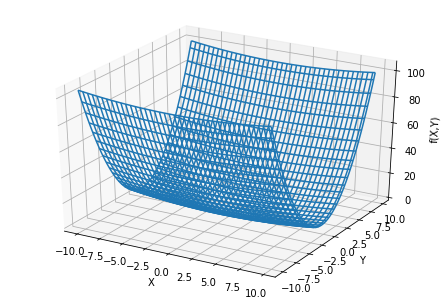

In [98]:
########
# 그림 6-1 그려보자 (CH04 실습 소스 참고)

from mpl_toolkits.mplot3d import Axes3D

x0 = np.arange(-10, 10, 0.25)
x1 = np.arange(-10, 10, 0.25)
X, Y = np.meshgrid(x0, x1)

# 2차원 meshgrid 좌표에 대응하는 각 X, Y 변수를 2변수 함수에 입력하기 위해 1차원으로 펼침
X = X.flatten()
Y = Y.flatten()

Z = f(X, Y)

# 계산된 함수값을 포함하여 meshgrid 형태에 맞게 원래 2차원 배열 형태로 재변환 
X = X.reshape(len(x0), len(x1))
Y = Y.reshape(len(x0), len(x1))
Z = Z.reshape(len(x0), len(x1))

fig = plt.figure()
ax = Axes3D(fig)
#ax = fig.gca(projection='3d')

#ax.plot_surface(X, Y, Z)
ax.plot_wireframe(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X,Y)')

#ax.view_init(elev=25, azim=-120) # 3d plot의 viewing angle을 교재와 비슷하게 변경
    
plt.show()

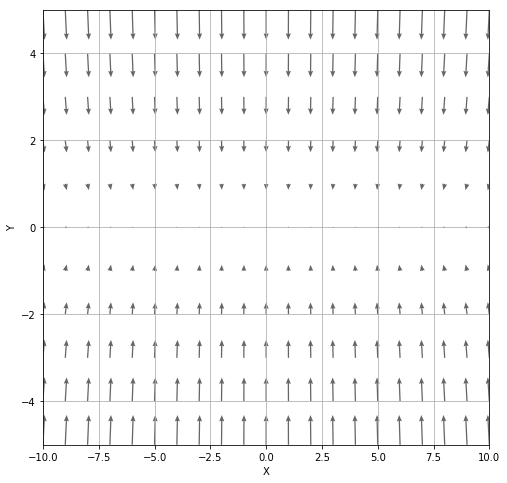

In [99]:
########
# 그림 6-2 그려보자 (CH04 실습 소스 참고)
X = np.arange(-10, 10.1, 1)
Y = np.arange(-10, 10.1, 1)

X, Y = np.meshgrid(X, Y)

X = X.flatten()
Y = Y.flatten()

grad = df(X, Y)

plt.figure(figsize=(8,8))
# quiver(): Plot a 2-D field of arrows. (quiver: 화살통이라는 뜻이 있나봄)
plt.quiver(X, Y, -grad[0], -grad[1],
           angles='xy', # (x,y) -> (x+u, y+v)
           color="#666666",
           headwidth=4, scale=150,
          )
plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
#plt.legend()
plt.draw()
plt.show()

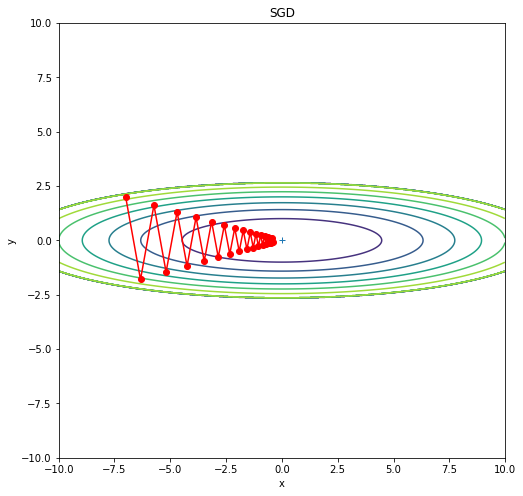

In [100]:
########
# 그림6-3 SGD에 의 한 최적화 갱신경로:
# 최솟값인 (0,0)까지 지그재그로 이동하니 비효율적이다

def draw_update_path(key, optimizer):
    init_pos = (-7.0, 2.0)
    params = {}
    params['x'], params['y'] = init_pos[0], init_pos[1]
    grads = {}
    grads['x'], grads['y'] = 0, 0

    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    plt.figure(figsize=(8,8))

    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()
    
draw_update_path(key = "SGD", optimizer=SGD(lr=0.95))

### 6.1.4 모멘텀

* 현재 속도(v) * 마찰(alpha) 항을 추가 

In [101]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

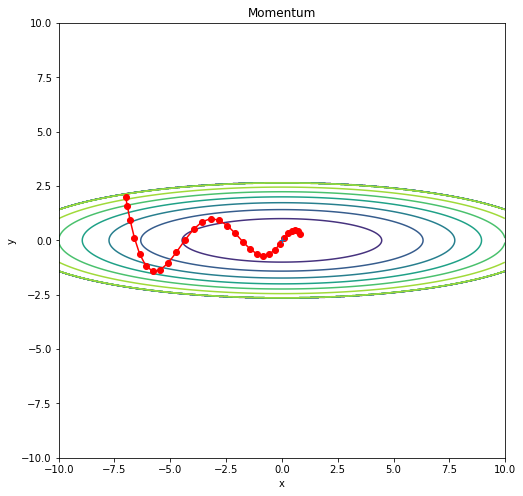

In [102]:
draw_update_path(key = "Momentum", optimizer=Momentum(lr=0.1))

* SGD와 비교하면 '지그재그 정도'가 덜함

### 6.1.5 AdaGrad

* 학습률 감소(learning rate decay): 학습을 진행하면서 학습률을 점차 줄여가는 방법
* AdaGrad: 개별 매개변수에 적응적으로(adaptive) 학습률을 조정하면서 학습을 진행

In [103]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 0으로 나누는 사태 막는 용도

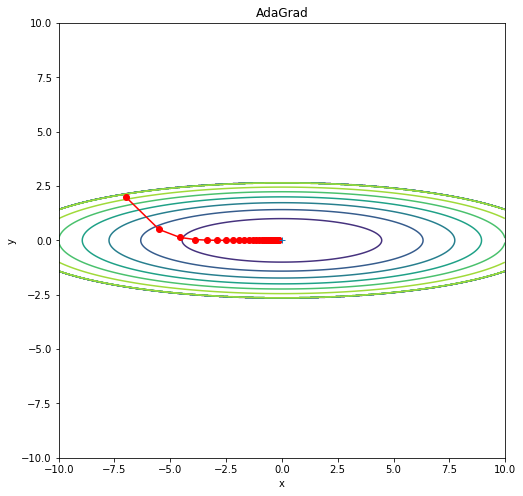

In [104]:
draw_update_path(key = "AdaGrad", optimizer=AdaGrad(lr=1.5))

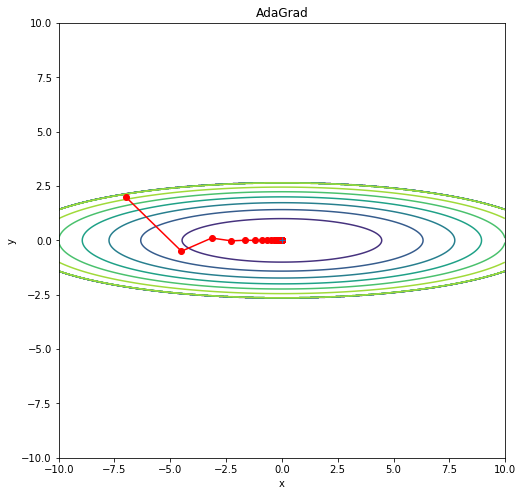

In [105]:
draw_update_path(key = "AdaGrad", optimizer=AdaGrad(lr=2.5))

* 최소값을 향해 효율적으로 움직임
* y축 방향은 기울기가 커서 처음에 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정됨

### 6.1.6 Adam

* AdaGrad (매개변수의 원소마다 적응적 갱신 정도 조정) 과 
* Momentum (그릇 바닥을 구르는 듯한 움직임)
* 이 두 기법을 융합 => Adam

* 하이퍼파라미터의 '편향 보정'이 진행된다는 점도 Adam의 특징

In [106]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
        self.iter += 1
        lr_t = (self.lr * np.sqrt(1.0 - self.beta2**self.iter) 
                / (1.0 - self.beta1**self.iter))
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

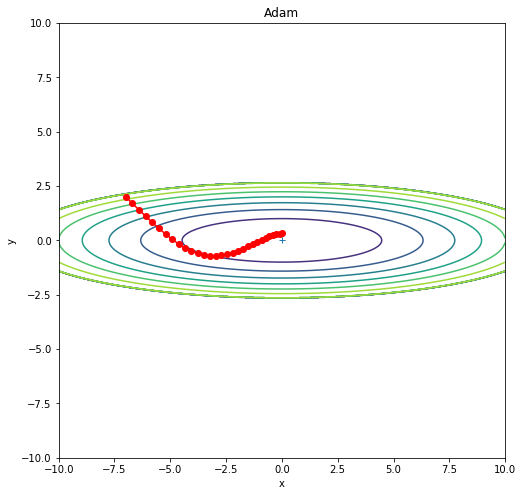

In [107]:
draw_update_path(key = "Adam", optimizer=Adam(lr=0.3))

* 모멘텀과 비슷하게 그릇 바닥을 구르듯 움직임
* 모멘텀보다 공의 좌우 흔들림이 적음: 학습 갱신 강도를 적응적으로 조정해서 얻는 혜택

* Adam의 하이퍼파라미터 3개
 - 학습률
 - 일차 모멘텀 계수 $\beta_{1}$ (0.9 설정 권장)
 - 이차 모멘텀 계수 $\beta_{2}$ (0.999 설정 권장)

### 6.1.7 어느 갱신 방법을 이용할 것인가?
* 문제에 따라, 하이퍼파라미터 설정에 따라 다름
* 이 책에서는 주로 SGD와 Adam을 사용...

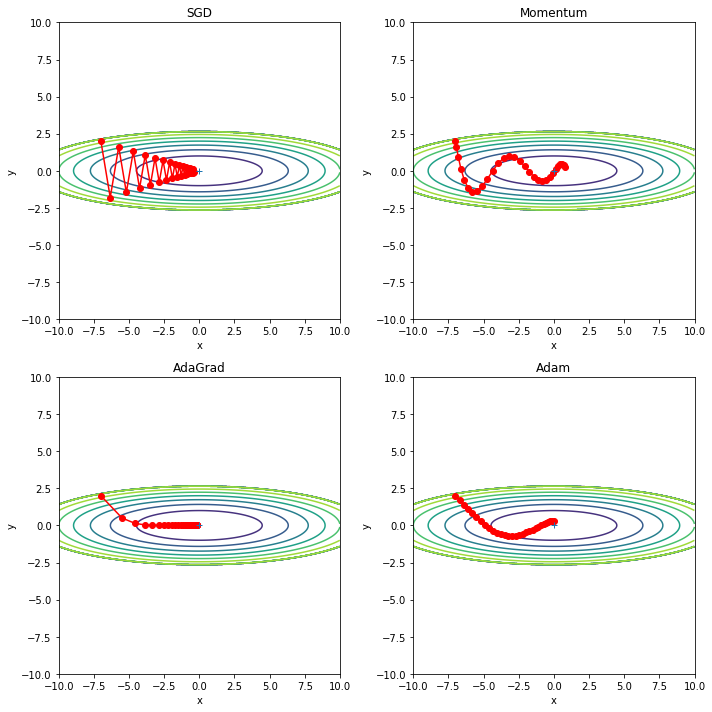

In [108]:
#######
# 위의 4개 그림을 한 번에 그림 (ch06/optimizer_compare_naive.py 참고)

plt.subplots(2, 2, figsize=(10,10))

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.tight_layout()
plt.show()

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

* 손글씨 숫자 인식에 각 최적화 기법을 적용 비교

In [110]:
# ch06/optimizer_compare_mnist.py 참고
# optimizer는 여기 실습 코드 작성한걸 사용

# src/common/layer의 import 변경 필요
# [BEFORE]
# from common.functions import *
# from common.util import im2col, col2im
# [AFTER]
# from .functions import *
# from .util import im2col, col2im

# src/common/multi_layer_net.py의 import 변경 필요
# [BEFORE]
#from common.layers import *
#from common.gradient import numerical_gradient
# [AFTER]
#from .layers import *
#from .gradient import numerical_gradient

# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from src.dataset.mnist import load_mnist
from src.common.util import smooth_curve
from src.common.multi_layer_net import MultiLayerNet
#from common.optimizer import *
from src.common.layers import *
from src.common.gradient import numerical_gradient

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
SGD:2.2919243964170226
Momentum:2.333679159522098
AdaGrad:1.9604326476004927
Adam:2.2027244463863185
===========iteration:100===========
SGD:1.642224885104089
Momentum:0.3417315710384482
AdaGrad:0.11379338173241033
Adam:0.24037340416008207
===========iteration:200===========
SGD:0.8821101660111414
Momentum:0.2762661896321849
AdaGrad:0.09587007649969342
Adam:0.1711828804316448
===========iteration:300===========
SGD:0.4982915346994106
Momentum:0.14855024831138428
AdaGrad:0.06753205642170904
Adam:0.10844229814770404
===========iteration:400===========
SGD:0.5329852955243409
Momentum:0.18468362394359947
AdaGrad:0.0738873890713293
Adam:0.11944632023268432
===========iteration:500===========
SGD:0.42164208590593544
Momentum:0.22685934269017144
AdaGrad:0.08145403127291903
Adam:0.13718344621971695
===========iteration:600===========
SGD:0.43348575253521515
Momentum:0.1613812187004276
AdaGrad:0.07044513467888061
Adam:0.09678800123343204
===========iteration:70

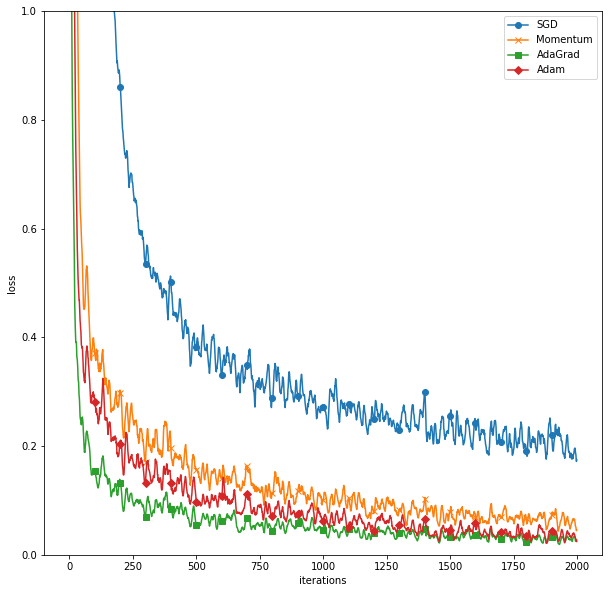

In [111]:
# 3. 그래프 그리기==========

plt.figure(figsize=(10,10))

markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

* 일반적으로 SGD보다 다른 세 기법이 빠르게 학습하고, 때로는 최종 정확도도 높게 나타남

## 6.2 가중치의 초기값

### 6.2.1 초기값을 0으로 하면?
* 순전파때 입력층의 가중치가 0이므로 두 번째 뉴런에 모두 같은 값이 전달되어,
* 갱신을 거쳐도 여전히 같은 값을 유지하게 됨

* "가중치가 고르게 되어버리는 상황"을 막기 위해 초기값을 무작위로 설정하는게 중요함

### 6.2.2 은닉층의 활성화값 분포

* 가중치의 초깃값에 따라 은닉층 활성화값들이 어떻게 변화하는지 간단한 실험

(1) sigmoid: 가중치를 표준편차가 1인 정규분포로 초기화할 때의 각 층의 활성화값 분포


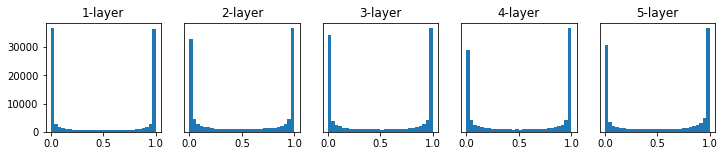

(2) sigmoid: 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포


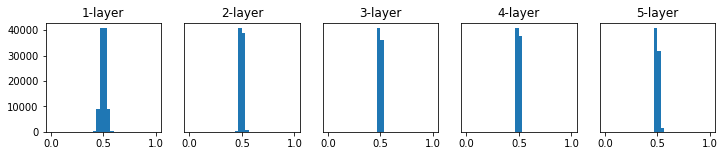

(3) sigmoid: 가중치의 초깃값으로 'Xavier 초깃값'(표준편차 sqrt(1/n))을 이용할 때의 각 층의 활성화값 분포


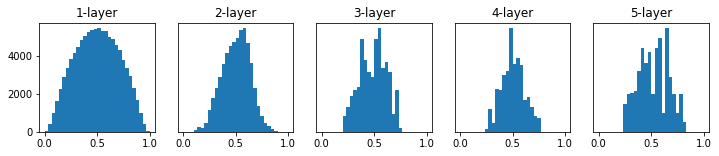

(4) ReLU: 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포


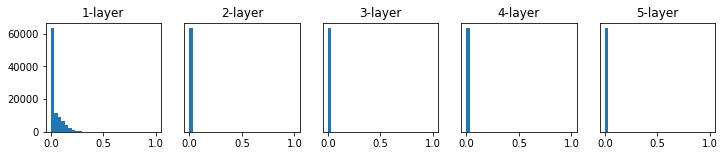

(5) ReLU: 가중치의 초깃값으로 'Xavier 초깃값'(표준편차 sqrt(1/n))을 이용할 때의 각 층의 활성화값 분포


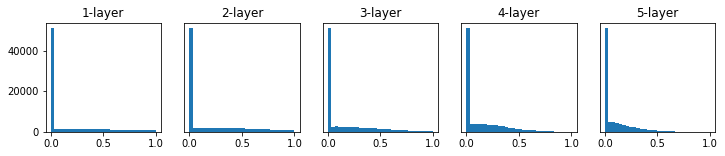

(6) ReLU: 가중치의 초깃값으로 'He 초깃값'(표준편차 sqrt(2/n))을 이용할 때의 각 층의 활성화값 분포


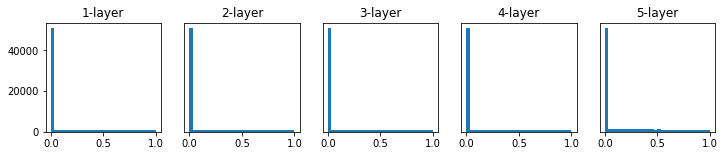

(7) tanh: 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포


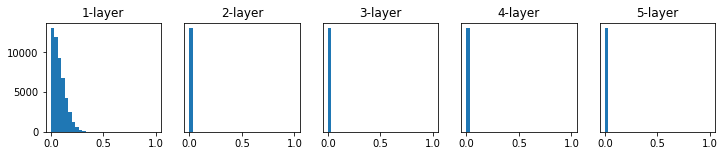

(8) tanh: 가중치의 초깃값으로 'Xavier 초깃값'(표준편차 sqrt(1/n))을 이용할 때의 각 층의 활성화값 분포


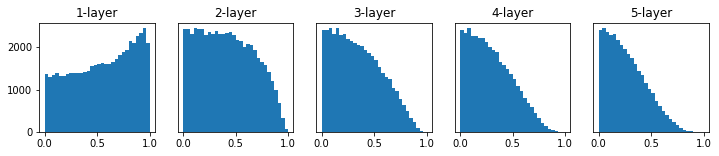

(9) tanh: 가중치의 초깃값으로 'He 초깃값'(표준편차 sqrt(2/n))을 이용할 때의 각 층의 활성화값 분포


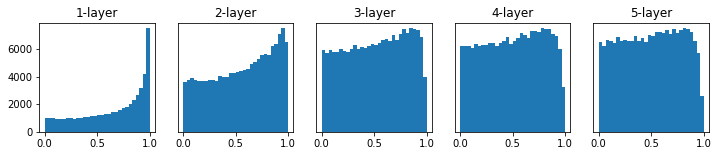

In [123]:
# ch06/weight_init_activation_histogram.py 참고

np.random.seed(0) # 재현가능용 seed 고정

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

cases = ["(1) sigmoid: 가중치를 표준편차가 1인 정규분포로 초기화할 때의 각 층의 활성화값 분포",
         "(2) sigmoid: 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포",
         "(3) sigmoid: 가중치의 초깃값으로 'Xavier 초깃값'(표준편차 sqrt(1/n))을 이용할 때의 각 층의 활성화값 분포",
         "(4) ReLU: 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포",
         "(5) ReLU: 가중치의 초깃값으로 'Xavier 초깃값'(표준편차 sqrt(1/n))을 이용할 때의 각 층의 활성화값 분포",
         "(6) ReLU: 가중치의 초깃값으로 'He 초깃값'(표준편차 sqrt(2/n))을 이용할 때의 각 층의 활성화값 분포",
         "(7) tanh: 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포",
         "(8) tanh: 가중치의 초깃값으로 'Xavier 초깃값'(표준편차 sqrt(1/n))을 이용할 때의 각 층의 활성화값 분포",
         "(9) tanh: 가중치의 초깃값으로 'He 초깃값'(표준편차 sqrt(2/n))을 이용할 때의 각 층의 활성화값 분포",
        ]

for c, case in zip([1,2,3,4,5,6,7,8,9], cases):
    print(case)

    plt.subplots(1, len(activations), figsize=(12,2))

    input_data = np.random.randn(1000, 100)  # 1000개의 데이터
    node_num = 100  # 각 은닉층의 노드(뉴런) 수
    hidden_layer_size = 5  # 은닉층이 5개
    activations = {}  # 이곳에 활성화 결과를 저장

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        # 초깃값을 다양하게 바꿔가며 실험해보자！
        if c in [1]:
            w = np.random.randn(node_num, node_num) * 1
        elif c in [2,4,7]:
            w = np.random.randn(node_num, node_num) * 0.01
        elif c in [3,5,8]:
            w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier 초깃값
        elif c in [6,9]:
            w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He 초깃값

        a = np.dot(x, w)


        # 활성화 함수도 바꿔가며 실험해보자！
        if c in [1,2,3]:
            z = sigmoid(a)
        elif c in [4,5,6]:
            z = ReLU(a)
        elif c in [7,8,9]:
            z = tanh(a)

        activations[i] = z



    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

In [126]:
# ch06/weight_init_compare.py 참고

from src.dataset.mnist import load_mnist
from src.common.util import smooth_curve
from src.common.multi_layer_net import MultiLayerNet
#from common.optimizer import SGD

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
std=0.01:2.3025034022058373
Xavier:2.2954364988417737
He:2.361068675470152
===========iteration:100===========
std=0.01:2.3031995943265366
Xavier:2.2426286739341714
He:1.649354181090383
===========iteration:200===========
std=0.01:2.3034353066351043
Xavier:2.162822900224768
He:0.8763410567078361
===========iteration:300===========
std=0.01:2.3039733931965847
Xavier:1.8497181284599613
He:0.6784247914602846
===========iteration:400===========
std=0.01:2.3046420233493086
Xavier:1.335536087972565
He:0.43835652442416273
===========iteration:500===========
std=0.01:2.2994873590193086
Xavier:0.9854198094079085
He:0.42478722730787083
===========iteration:600===========
std=0.01:2.3025423991475287
Xavier:0.7114776230534068
He:0.32608817730326645
===========iteration:700===========
std=0.01:2.2997789020471293
Xavier:0.5870551606854857
He:0.3907142780482956
===========iteration:800===========
std=0.01:2.3002800356108564
Xavier:0.4627841810333708
He:0.237573054135

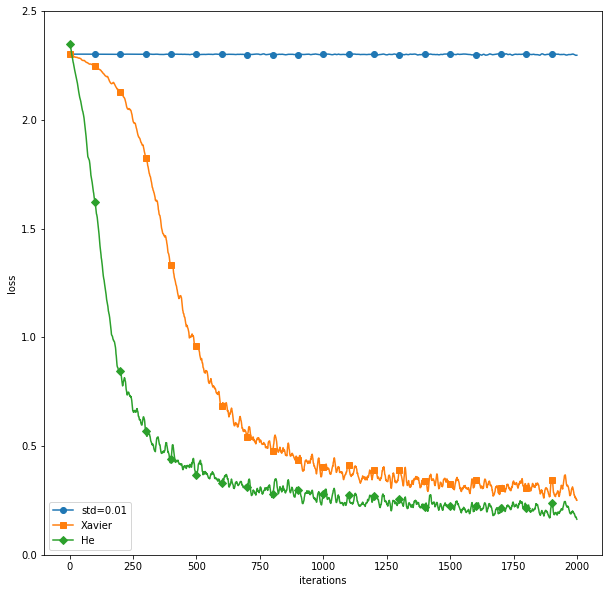

In [127]:
# 3. 그래프 그리기==========
plt.figure(figsize=(10,10))

markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

* std=0.01 일때 학습이 전혀 이뤄지지 않음: 순전파때 너무 작은 값이 흐르기 때문
* Xavier와 He 초깃값의 경우 학습이 순조롭게 이루어짐
* 학습진도는 He 초깃값이 더 빠름

## 6.3 배치 정규화

In [134]:
# 6.3.2 배치 정규화의 효과

# 배치 정규화 계층을 사용할 때와 사용하지 않을 때의 학습 진도가 어떻게 달라지는지 확인

from src.common.multi_layer_net_extend import MultiLayerNetExtend
"""
#from common.layers import *
#from common.gradient import numerical_gradient
from .layers import *
from .gradient import numerical_gradient
"""

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            #print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

============== 1/16 ==============


../src/common/multi_layer_net_extend.py:106: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
../src/common/multi_layer_net_extend.py:106: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
../src/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
../src/common/layers.py:14: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
/Users/a60029864/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


============== 2/16 ==============


/Users/a60029864/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


============== 3/16 ==============
============== 4/16 ==============
============== 5/16 ==============
============== 6/16 ==============
============== 7/16 ==============
============== 8/16 ==============
============== 9/16 ==============
============== 10/16 ==============
============== 11/16 ==============
============== 12/16 ==============
============== 13/16 ==============
============== 14/16 ==============
============== 15/16 ==============
============== 16/16 ==============


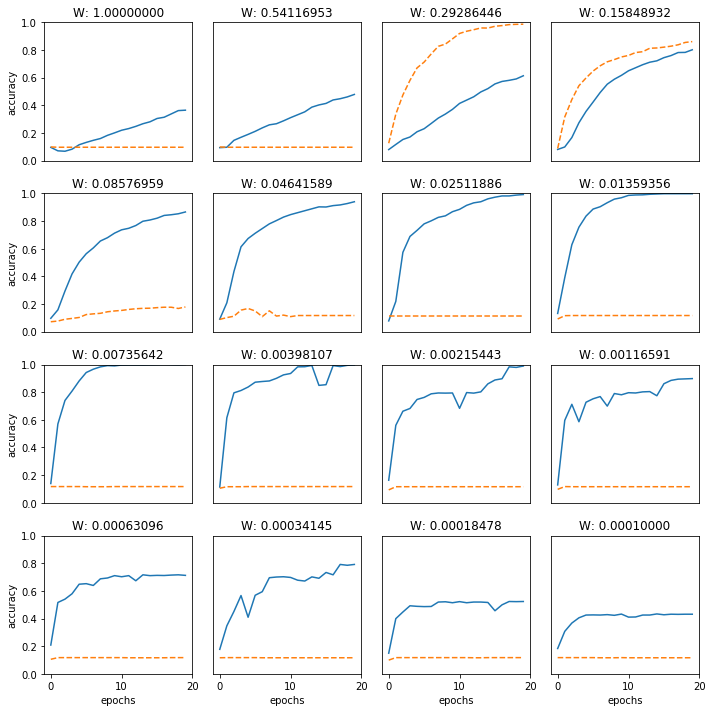

In [137]:
# 그래프 그리기==========
plt.subplots(4,4, figsize=(10,10))

weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    #plt.title("W:" + str(w))
    plt.title("W: %.8f" % w)
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    #plt.legend(loc='lower right')
    
plt.tight_layout()
plt.show()


## 6.4 바른 학습을 위해

### 6.4.1 오버피팅
* 매개변수가 많고 표현력이 높은 모델
* 훈련데이터가 적음

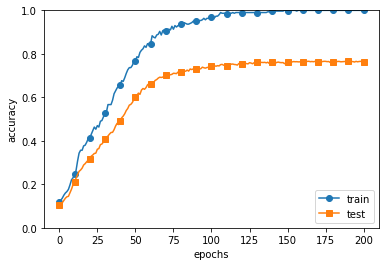

In [140]:
# ch06/overfit_weight_decay.py

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        #print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 6.4.2 가중치 감소 

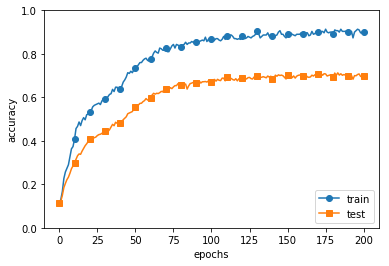

In [141]:
# ch06/overfit_weight_decay.py

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        #print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

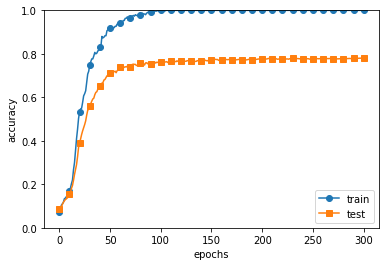

In [147]:
# 6.4.3 드롭아웃
# ch06/overfit_dropout.py

from src.common.trainer import Trainer
"""
#from common.optimizer import *
from .optimizer import *
"""

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = False  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

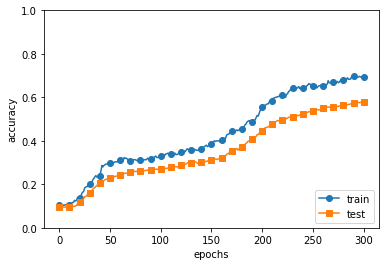

In [148]:
# 6.4.3 드롭아웃
# ch06/overfit_dropout.py

from src.common.trainer import Trainer
"""
#from common.optimizer import *
from .optimizer import *
"""

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.5 적절한 하이퍼파라미터 값 찾기

### 6.5.1 검증 데이터 (validation data)
* 하이퍼파라미터 조정용 데이터

### 6.5.2 하이퍼파라미터 최적화
### 6.5.3 하이퍼파라미터 최적화 구현하기

In [150]:
# ch06/hyperparameter_optimization.py

from src.common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.7) | lr:0.006030753466622731, weight decay:8.12818684803632e-08
Best-2(val acc:0.64) | lr:0.005822530521694772, weight decay:6.917987997531188e-08
Best-3(val acc:0.62) | lr:0.0051473541545205585, weight decay:5.401574202999331e-06
Best-4(val acc:0.6) | lr:0.004134416242131453, weight decay:1.111570752751847e-08
Best-5(val acc:0.47) | lr:0.0035768088506507563, weight decay:8.04792600502453e-06
Best-6(val acc:0.47) | lr:0.003675801249331202, weight decay:1.1417494520050105e-08
Best-7(val acc:0.46) | lr:0.004396502928278026, weight decay:3.834617473340113e-05
Best-8(val acc:0.46) | lr:0.0037545780437186495, weight decay:1.2617526751023244e-06
Best-9(val acc:0.45) | lr:0.0020121813724219544, weight decay:6.733367598058655e-08
Best-10(val acc:0.44) | lr:0.003320119999608863, weight decay:2.534059241795624e-08
Best-11(val acc:0.43) | lr:0.003262675994953453, weight decay:3.425597881452381e-07
Best-12(val acc:0.41) |

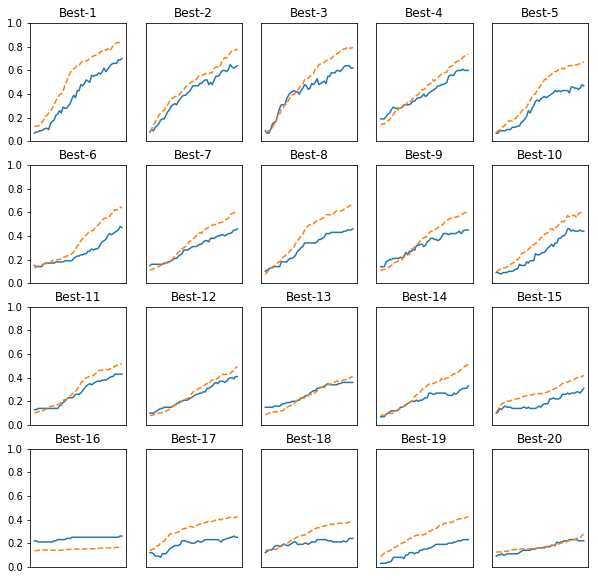

In [151]:
# 그래프 그리기========================================================

print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.subplots(row_num, col_num, figsize=(10,10))

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()